Copyright 2020-2022 John Penuel.  All rights reserved.


# Fekete Points


This notebook explores some randomized greedy heuristics to optimize the Fekete Points problem.  The Fekete Points problem seeks to minimize the "potential energy" of a system of points confined to a unit sphere.  The points repel each other, so if points are clumped closely together, the potential energy of the system is high.  You can think of this as electrons on a sphere.  At a minimum energy configuration, the points will be spread out evenly on the surface of the sphere.  

The position of point $i$ is $x_i$ and the position of point $j$ is $x_j$.  The contribution to the total energy of the system from these points is
\begin{align}
||x_i - x_j||^{-s} &= \frac{1}{||x_i - x_j||^{s}}
\end{align}
When point $i$ is close to point $j$, then $||x_i - x_j||$ is small but $\frac{1}{||x_i - x_j||^{s}}$ is large.

The aggregate energy of the system is
\begin{align}
f(x) &= \sum_{\{i,j : i < j\}}||x_i - x_j||^{-s}
\end{align}

$s \gt 0$ and we use $s=1$ in most of the following calculations.

More details on the specific formulations can be found here:

* https://en.wikipedia.org/wiki/Fekete_problem
* https://en.wikipedia.org/wiki/Thomson_problem


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [2]:
#number of points
m = 30

#dimension of space... this code is not generic at this point 
# and changing n!=3 will break plotting.
n = 3

#s-parameter
s = 1


#set random seed for repeatability
np.random.seed(17)  
      

We define random starting positions for the system, normalized to the unit sphere.

In [3]:
starting_point = np.random.rand(n,m)
starting_point = starting_point - 0.5*np.ones((n,m))
for i in range(m):
    starting_point[:,i] = starting_point[:,i]/np.linalg.norm(starting_point[:,i])

The following ```plot_points``` function plots all points in 3D space with lines between all pairs.  The width of the line is inversely proportional to the distance between points.

In [4]:
def plot_points(point,s):
    (n,m) = point.shape
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [10, 10]
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point[0,:], point[1,:], point[2,:],c='r',s=20)
    ax.axis('off')
    cmax = 0
    for i in range(m-1):
        for j in range(i+1,m):
            c = np.linalg.norm(point[:,i]-point[:,j])**-s
            cmax = max(cmax,c)
    for i in range(m-1):
        for j in range(i+1,m):
            c = np.linalg.norm(point[:,i]-point[:,j])**-s
            ax.plot(point[0,[i,j]],
                point[1,[i,j]],
                point[2,[i,j]],
                color='blue',
                linewidth=c/cmax)
    plt.show()

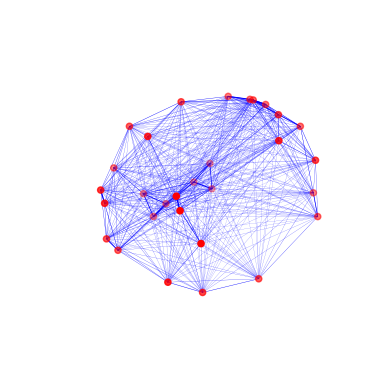

In [5]:
plot_points(starting_point,s)

The following ```plot_points2``` function only plots the outermost triangles with point vertices.  So it's more visually appealing.  We acknowledge that all pairs of points contribute to the energy of the system, but we just aren't plotting all line segments between all pairs.

In [6]:
def plot_points2(point,s):
    (n,m) = point.shape
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point[0,:], point[1,:], point[2,:],c='r',s=20)
    ax.axis('off')
    triangles = []
    for i in range(m-2):
        for j in range(i+1,m-1):
            for k in range(j+1,m):
                t = np.cross(point[:,j]-point[:,i],point[:,k]-point[:,i])
                kquit = 0
                sLow = []
                sHigh = []
                for el in range(m):
                    if el != i:
                        if el != j:
                            if el != k:
                                c = np.dot(t,(point[:,el]-point[:,i]))
                                if c < 0:
                                    sLow.append(el)
                                else:
                                    sHigh.append(el)
                                if len(sLow) > 0 and len(sHigh) > 0:
                                    kquit = 1
                                    break
                if kquit == 0:
                    triangles.append([i,j,k])
    for t in triangles:
        i = t[0]
        j = t[1]
        k = t[2]
        c = np.linalg.norm(point[:,i]-point[:,j])**-s
        ax.plot(point[0,[i,j]],point[1,[i,j]],point[2,[i,j]],color='blue',
            linewidth=c/2)
        c = np.linalg.norm(point[:,i]-point[:,k])**-s
        ax.plot(point[0,[i,k]],point[1,[i,k]],point[2,[i,k]],color='blue',
            linewidth=c/2)
        c = np.linalg.norm(point[:,j]-point[:,k])**-s
        ax.plot(point[0,[j,k]],point[1,[j,k]],point[2,[j,k]],color='blue',
            linewidth=c/2)
    plt.show()    

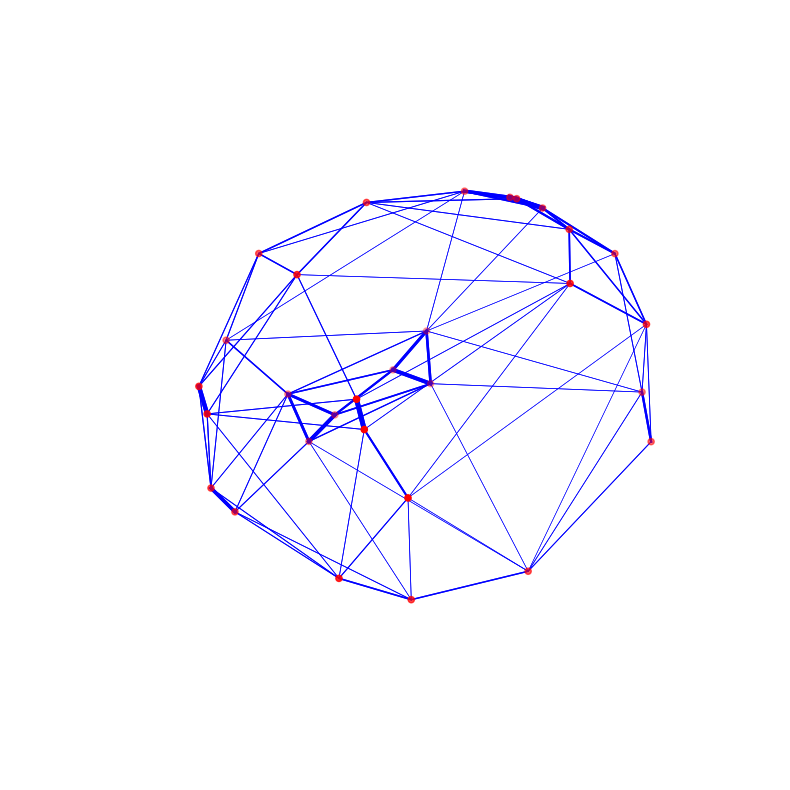

In [7]:
plot_points2(starting_point,s)

The following ```evaluate_objective``` function takes a set of $m$ points as
column vectors in a NumPy array and an $s$-energy parameter and returns the
aggregate energy of the system.

In [8]:
def evaluate_objective(points,s):
    (n,m) = point.shape
    obj = 0
    for i in range(m-1):
        for j in range(i+1,m):
            obj = obj + np.linalg.norm(point[:,i] - point[:,j])**-s
    return obj

### (H=0) Pick-one-and-wiggle-it Heuristic:

We will write a few heuristics to try and find the positions of points that minimize the aggregate energy of the system.  The first one we are going to try will pick one point at random, and randomly move it.  If the aggregate energy of the system is lower in the new configuration, it will be saved as the new best configuration.  Else, we'll try to wiggle a different point.  This is a very simple heuristic.

For each of the following heuristics, we will simply run them for a fixed number of iterations and monitor the energy of the system at each iteration.  Then we will compare the results at the end.

In [9]:
iterations = 1500
performance = np.zeros((4,iterations))

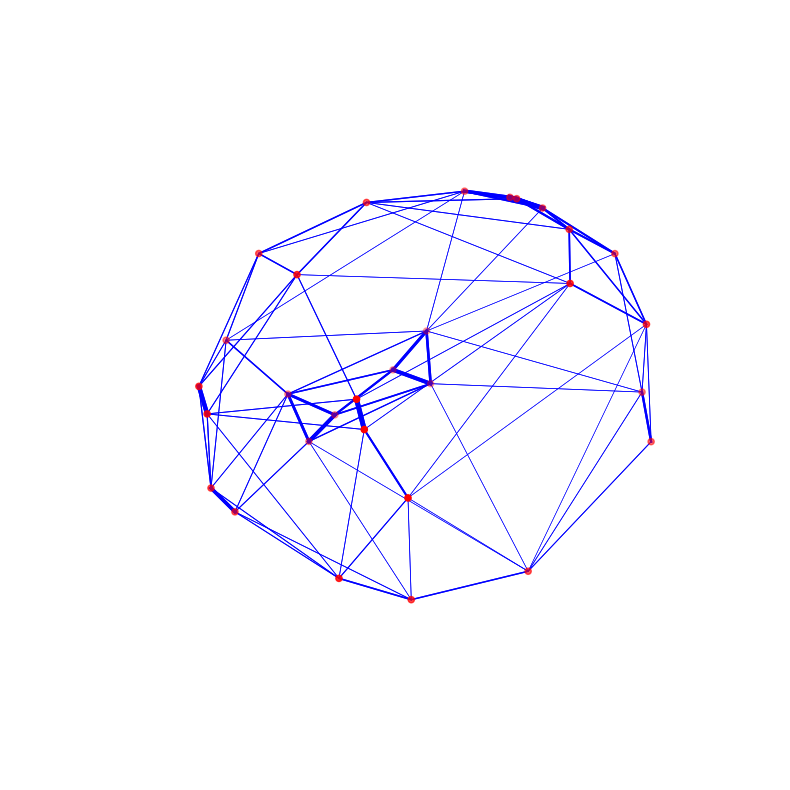

In [10]:
heuristic = 0
point = np.copy(starting_point)


epsilon = 0.1 
# epsilon may be tuned.  
# epsilon is the step size of the random jump *before* the new point
# is scaled back to the unit sphere.


for itr in range(iterations):
    c = evaluate_objective(point,s)
    performance[heuristic,itr] = c
    i = np.random.randint(m)
    temp_point = np.copy(point)
    temp_point[:,i] = temp_point[:,i] + epsilon*(np.random.rand(3) - 0.5*np.ones(3))
    temp_point[:,i] = temp_point[:,i]/np.linalg.norm(temp_point[:,i])
    c_temp = evaluate_objective(temp_point,s)
    if c_temp < c:
        c = c_temp
        point = np.copy(temp_point)
    performance[heuristic,itr] = c
        
        
plot_points2(point,s)

### (H=1) Pick-one-and-push-it Heuristic:

We pick one point *at random* and move it in a direction that reduces the energy of the system.

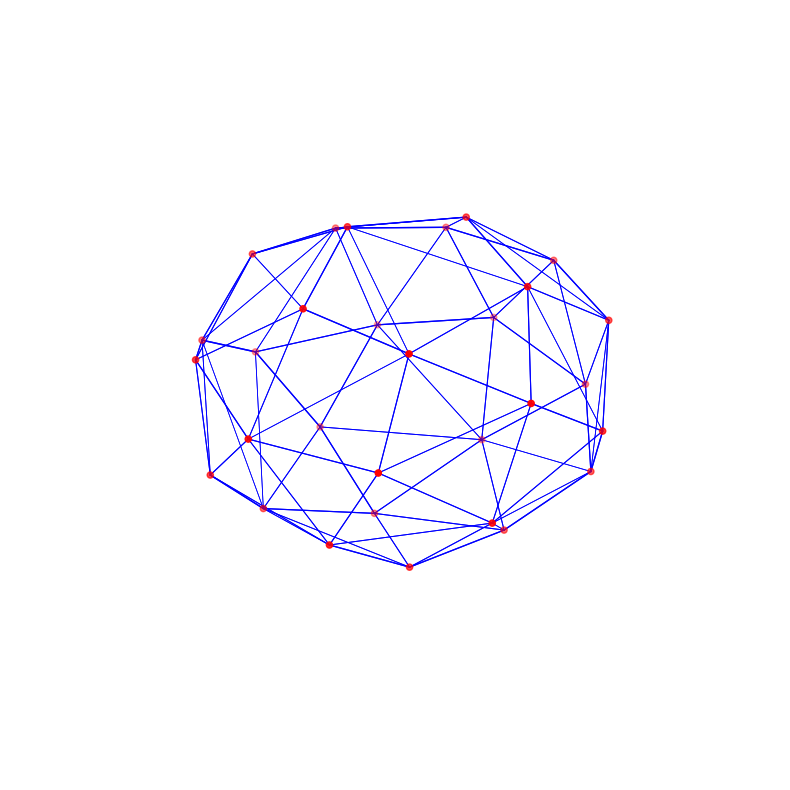

In [11]:
heuristic = 1
point = np.copy(starting_point)


epsilon = 0.1 #epsilon may be tuned.

for itr in range(iterations):
    c = evaluate_objective(point,s)
    performance[heuristic,itr] = c
    i = np.random.randint(m)
    d = np.zeros(3)
    for j in range(m):
        if i != j:
            v = point[:,i] - point[:,j]
            a = np.linalg.norm(v)**-s
            v = a*v
            d = d + v
    d = epsilon*d
    point[:,i] = point[:,i] + d
    point[:,i] = point[:,i]/np.linalg.norm(point[:,i])

            
plot_points2(point,s)

### (H=2) Select-node-with-most-potential-and-push-it Heuristic:

We pick the point that contributes the most energy to the system and move that point in a direction that reduces the energy of the system.  Note that this heuristic is deterministic.

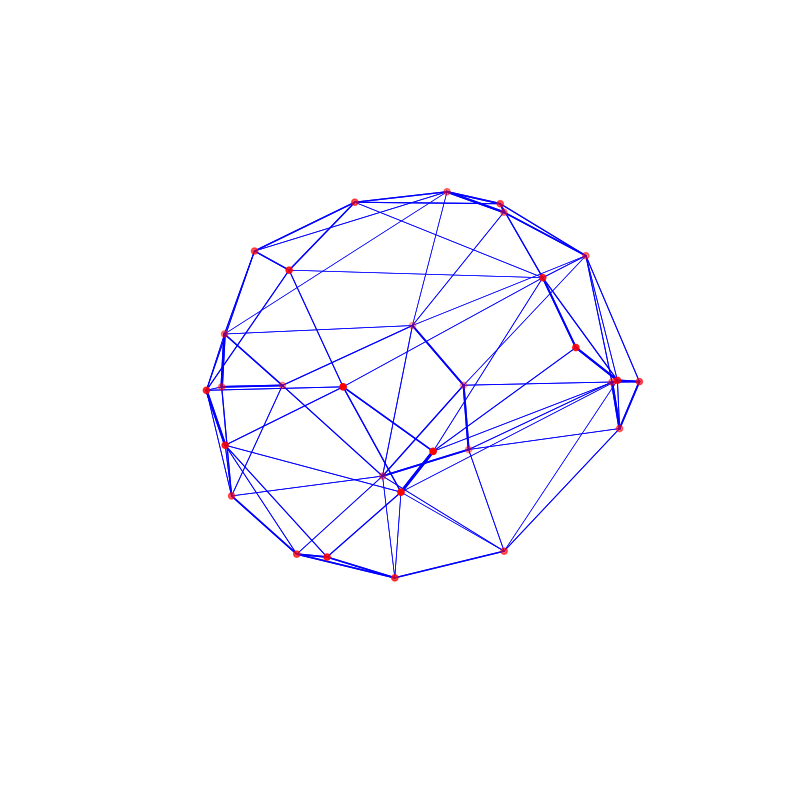

In [12]:
heuristic = 2
point = np.copy(starting_point)


epsilon = 0.1 #epsilon may be tuned.

for itr in range(iterations):
    c = evaluate_objective(point,s)
    performance[heuristic,itr] = c
    max_e = 0
    ii = 0
    for i in range(m):
        e = 0
        for j in range(m):
            if i != j:
                e = e + np.linalg.norm(point[:,i]-point[:,j])**-s
        if e > max_e:
            max_e = e
            ii = i
    i = ii
    d = np.zeros(3)
    for j in range(m):
        if i != j:
            v = point[:,i] - point[:,j]
            a = np.linalg.norm(v)**-s
            v = a*v
            d = d + v
    d = epsilon*d
    point[:,i] = point[:,i] + d
    point[:,i] = point[:,i]/np.linalg.norm(point[:,i])
    
            
plot_points2(point,s)

### (H=3) Select-node-with-most-potential-and-push-it heuristic ... with simulated annealing:

We follow the same procedure as Heuristic 2, but if the energy of the system is not sufficiently reduced enough between iterations, we introduce some random jiggling of points.  This random jiggling may temporarily *increase* the energy of the system, but will allow the heuristic to explore more of the solution space.

Annealing is a term taken from metallurgy.  As a metal part is manufactured, while cooling down, the part may be heated again.  Heating the metal repeatedly as it cools down allows the molecules to reorganize and potentially improve their crystalline organization.

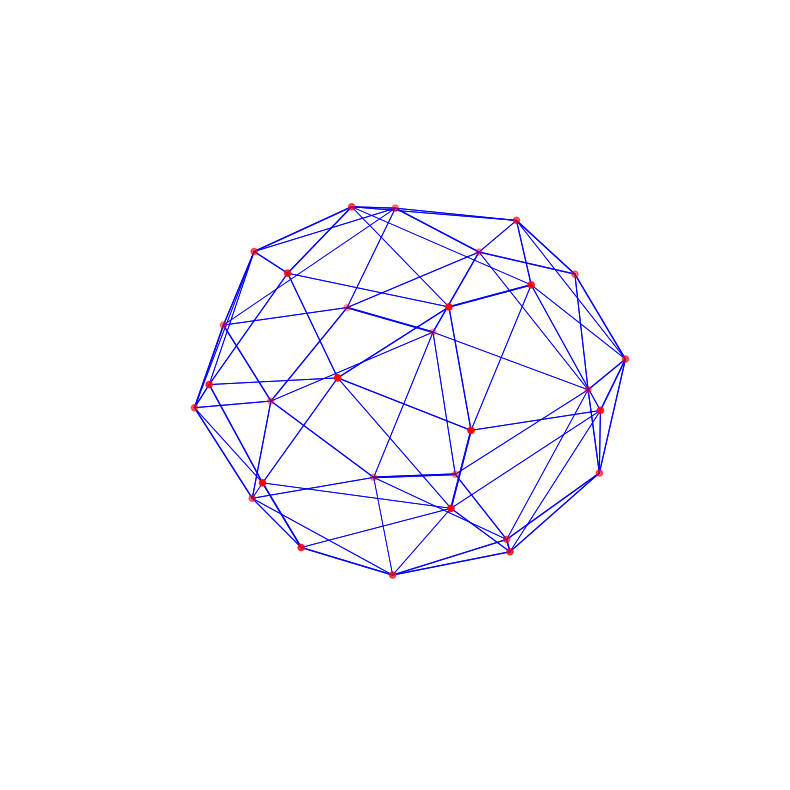

In [13]:
heuristic = 3
point = np.copy(starting_point)

epsilon = 0.1 #epsilon may be tuned.

for itr in range(iterations):
    c = evaluate_objective(point,s)
    performance[heuristic,itr] = c
    if itr > 0:
        if abs(performance[heuristic,itr] - performance[heuristic,itr-1]) < 0.005: 
            #stagnant. jiggle it.
            for i in range(m):
                point[:,i] = point[:,i] + 0.01*(np.random.rand(3) - 0.5*np.ones(3))
                point[:,i] = point[:,i]/np.linalg.norm(point[:,i])
    max_e = 0
    ii = 0
    for i in range(m):
        e = 0
        for j in range(m):
            if i != j:
                e = e + np.linalg.norm(point[:,i]-point[:,j])**-s
        if e > max_e:
            max_e = e
            ii = i
    i = ii
    d = np.zeros(3)
    for j in range(m):
        if i != j:
            v = point[:,i] - point[:,j]
            a = np.linalg.norm(v)**-s
            v = a*v
            d = d + v
    d = epsilon*d
    point[:,i] = point[:,i] + d
    point[:,i] = point[:,i]/np.linalg.norm(point[:,i])
    
    
        
plot_points2(point,s)

### Results

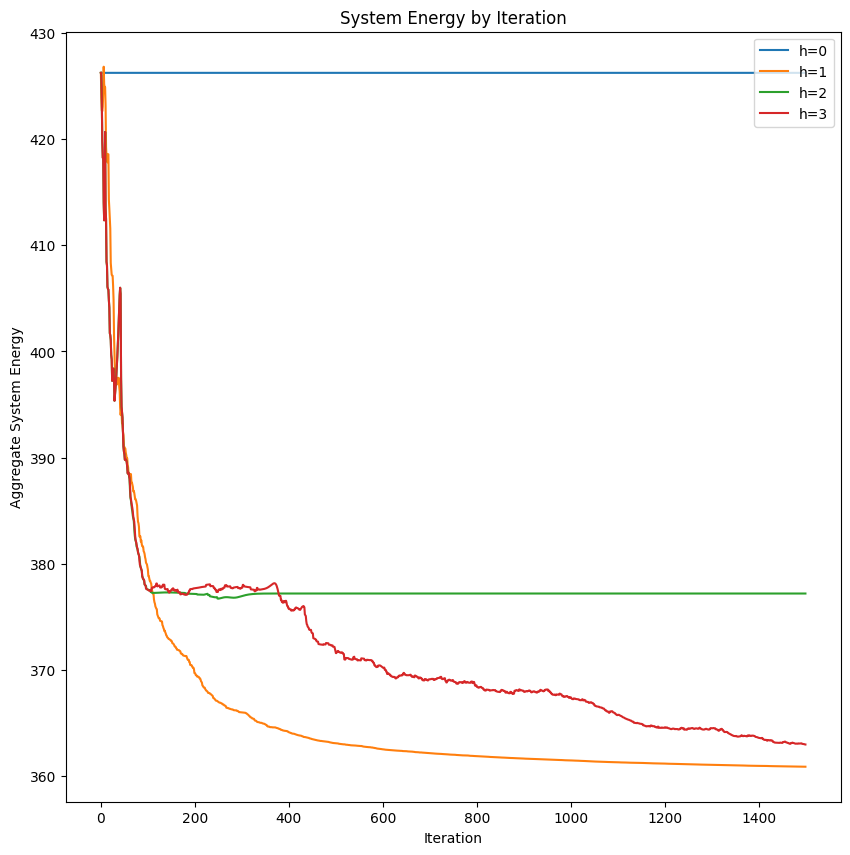

In [14]:


ax = plt.subplot(111)
(H,t) = performance.shape
for heuristic in range(H):
    plt.plot(performance[heuristic,:], label=f"h={heuristic}")
    
plt.legend(loc='upper right')
plt.title("System Energy by Iteration")
plt.xlabel("Iteration")
plt.ylabel("Aggregate System Energy")

plt.show()

* Heuristic 0 (H=0): pick random point, random move, only accept solution if better
* Heuristic 1 (H=1): pick random point, move in improving direction
* Heuristic 2 (H=2): pick point with most energy, move in improving direction
* Heuristic 3 (H=3): Same as H=2, but with simulated annealing

Heuristic 1 seems to have the best performance.

Heuristic 2 drives the system down to a minimum slightly faster, but gets stuck in a local minimum (as opposed to global) and fails to make any more progress.  It may have worked better with a different set of starting points.  Since it's deterministic as opposed to random movement, it may fail to explore the full solution space and get trapped in a local minimum.

The added randomized selection in Heuristic 1 helps it to avoid the local minimum trap.


Heuristic 3 is just adding additional randomized movement to the system in an attempt to bump Heuristic 2 out of the local minimum. Heuristic 3 gets itself out of the local minimum trap, but still doesn't converge as fast as we want it to.  The performance comparable to the completely random Heuristic 0.


Future improvements may include parameterizing and tuning all search, selection, movement and convergence thresholds. The most likely parameter to enhance performance would be optimizing (at each iteration) the distance that the point is moved instead of a fixed jump size.